In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from time import time
import cv2
from pylab import rcParams
import json
from functions import *
%matplotlib inline

Using TensorFlow backend.


In [3]:
# load json and create model
from keras.models import model_from_json
json_file = open('7conv_test_2class.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
entrada (Conv2D)             (None, 222, 222, 32)      896       
_________________________________________________________________
batch_norm_0 (BatchNormaliza (None, 222, 222, 32)      128       
_________________________________________________________________
activation_0 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling_0 (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2D_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 109, 109, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 64)      0         
__________

In [4]:
loaded_model.load_weights('weights_224_n12t.h5')

In [5]:
# Load npz file containing image arrays
x_npz = np.load("x_Pneumothorax_balanced_224.npz")
x = x_npz['arr_0']
# Load binary encoded labels for Lung Infiltrations: 0=disiese not found 1=disiese found
y_npz = np.load("y_Pneumothorax_balanced_224.npz")
y = y_npz['arr_0']

In [6]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y),y)
print(class_weights)

[ 1.08187006  0.92964919]


In [7]:
# First split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_valtest, y_train, y_valtest = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)

# Second split the 20% into validation and test sets
X_test, X_val, y_test, y_val = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=1, stratify=y_valtest)

In [8]:
nb_categories = 2

#use this to compare if label binarize is better than to_categorical
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train,nb_categories)
y_test = np_utils.to_categorical(y_test,nb_categories)
y_valtest = np_utils.to_categorical(y_valtest,nb_categories)
y_val = np_utils.to_categorical(y_val,nb_categories)

In [9]:
import sklearn
import itertools
from sklearn.metrics import confusion_matrix
dict_characters = { 1: 'Pneumothorax Observed', 0: 'No Pneumothorax Observed'}#['Infiltration Observed', 'No Infiltration Observed']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',fontsize=20,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=17)
    plt.yticks(tick_marks, classes,fontsize=17)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black", fontsize=20)

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)

In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=True, rotation_range=30)
valtest_datagen = ImageDataGenerator(rescale=1. / 255)

In [11]:
#The default behavior of flow_from_directory is to shuffle the data; 
#this means that the predictions from predict generator will not correspond to the ground truth labels 
#which you get from test_generator.classes. So set shuffle = False
batch_size = 16
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)

train_generator = train_datagen.flow(np.array(X_train), y_train, batch_size=batch_size,shuffle=False)
validation_generator = valtest_datagen.flow(np.array(X_val), y_val, batch_size=batch_size, shuffle=False)
test_generator = valtest_datagen.flow(np.array(X_test), y_test, batch_size=batch_size,shuffle=False)

In [12]:
a=X_train
b=y_train
c=X_valtest
d=y_valtest
Y_pred = loaded_model.predict_generator(validation_generator,nb_validation_samples // batch_size+1)
Y_pred_classes = np.argmax(Y_pred,axis=1) 

In [13]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(validation_generator.y,axis=1), Y_pred_classes, target_names=list(dict_characters.values())))


                          precision    recall  f1-score   support

No Pneumothorax Observed       0.56      0.94      0.70       455
   Pneumothorax Observed       0.88      0.38      0.53       531

             avg / total       0.73      0.64      0.61       986



In [14]:
cnf_matrix = confusion_matrix(np.argmax(validation_generator.y, axis=1), Y_pred_classes)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[426  29]
 [328 203]]


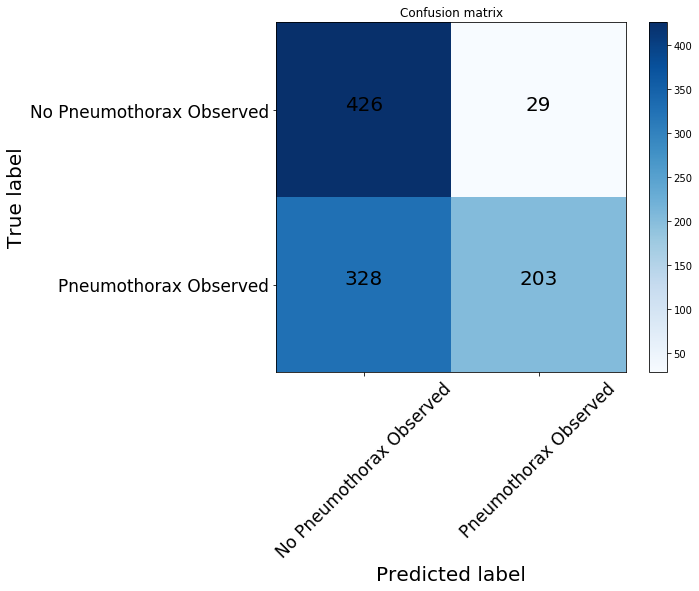

In [15]:
# Plot non-normalized confusion matrix
plt.figure(figsize=[10,8])
plot_confusion_matrix(cnf_matrix, classes=list(dict_characters.values()),
                      title='Confusion matrix')
#plt.savefig("/home/felipe/Dropbox/ML_diagnostics/draft/Felipe_notes/fig/confusion_matrix_Infiltration.pdf")
plt.show()

Normalized confusion matrix
[[ 0.94  0.06]
 [ 0.62  0.38]]


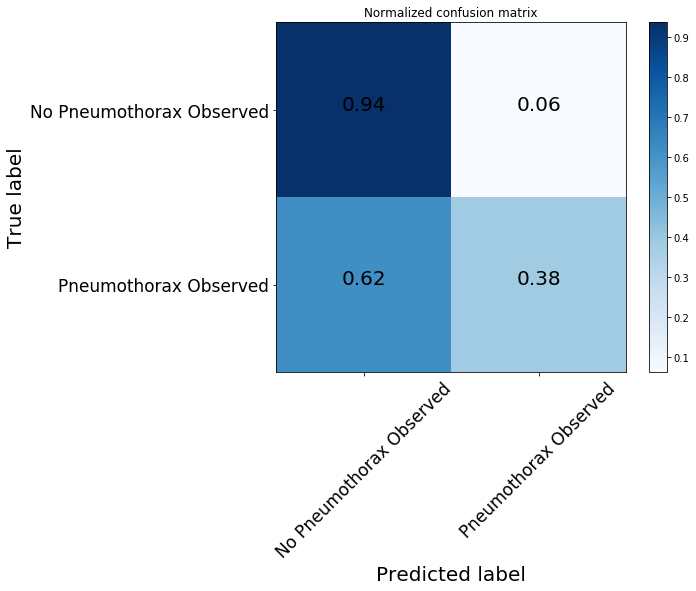

In [16]:
plt.figure(figsize=[10,8])
plot_confusion_matrix(cnf_matrix, classes=dict_characters.values(), normalize=True,
                      title='Normalized confusion matrix')

#plt.savefig("figs/norm_CM_balanced_2xtra.pdf")
plt.show()

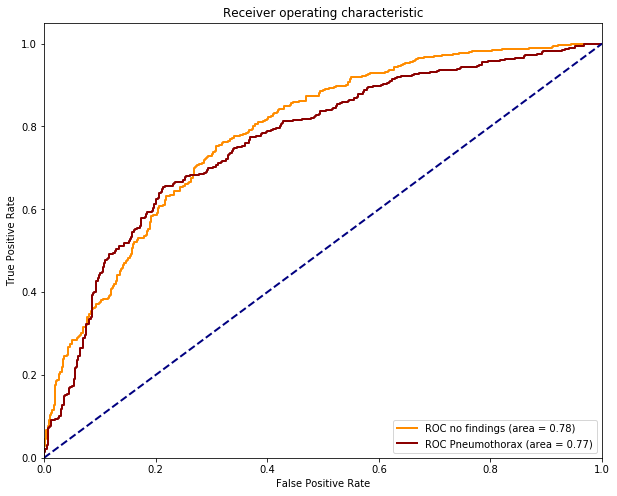

In [17]:
from sklearn.metrics import roc_curve, auc

fpr0, tpr0, thresholds0 = roc_curve(validation_generator.y[:,0], Y_pred[:,0])
fpr1, tpr1, thresholds1 = roc_curve(validation_generator.y[:,1], Y_pred[:,1])
roc_auc0 = auc(fpr0, tpr0)
roc_auc1 = auc(fpr1, tpr1)

plt.figure(figsize=[10,8])
lw = 2
plt.plot(fpr0, tpr0, color='darkorange',
         lw=lw, label='ROC no findings (area = %0.2f)'%(roc_auc0))
plt.plot(fpr1, tpr1, color='darkred',
         lw=lw, label='ROC Pneumothorax (area = %0.2f)'%(roc_auc1))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('figs/ROC_2extra.pdf')
plt.show()